In [8]:
%matplotlib inline

In [9]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import h5py, pylab, struct
import matplotlib.cm as cm
import conversions as co
import pandas as pd

#### TODO:
* PLOTS

#### Aspirations:
* Wrap the hdf5 reader such that it can read in chunks at a time

#### Notes:
* snap hdf5 structure: f has keys 'Header', 'PartType1,2,3'
* PartTypes have no attrs, keys = "Coordinates", "ParticleIDs", "Velocities" with no attrs
    * Coords and Vels are ndarrays len == 3
    * PT1=DM (20mil x 3), PT2=disk (8mil x 3), PT3=bulge (2.8mil x 3)
* header has attributes with value == 0: 
    * BoxSize, OmegaLambda, Redshift
    * Flag_[Cooling, DoublePrecision, Feedback, IC_Info, Metals, Sfr, StellarAge]
* nonzero attrs: 
    * HubbleParam, Omega0 == 1, Time (in years / 10^9 (????))
    * NumPart_ThisFile == NumPart_Total (array len 6), MassTable (array len 6)

In [94]:
def read_hdf5(path, p_type=1):
    """types: 1=DM, 2=disk, 3=bulge"""
    groups = ["Header", "PartType1", "PartType2", "PartType3"]
    head = {}
    
    f = h5py.File(path, "r")
    h = f["Header"]
    keys = list(h.attrs)
    for key in keys:
        head[key] = h.attrs[key]
    parts = f[groups[p_type]]
    columns = ["x","y","z", "vx", "vy", "vz"]
    df = pd.DataFrame(np.concatenate((parts["Coordinates"], parts["Velocities"]), axis=1),
                     columns=columns, index=parts["ParticleIDs"][:])
    f.close()
    
    return head, df

def df_center(df):
    idxs = ['x', 'y', 'z']
    for idx in idxs:
        df[idx] -= df[idx].median()
        
def df_polar(df):
    df['r'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
    df['phi'] = np.arctan2(df['y'], df['x'])
    # (x xdot + y ydot) / (sqrt(x^2 + y^2))
    df['vr'] = (df['x'] * df['vx'] + df['y'] * df['vy']) / df['r']
    # (x ydot - y xdot) / (x^2 + y^2)
    df['vphi'] = (df['x'] * df['vy'] - df['y'] * df['vx']) / (df['r'] ** 2)

In [98]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=1)
df_center(df)
df_polar(df)

In [174]:
df.describe()

,x,y,z,vx,vy,vz,r,phi,vr,vphi
count,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07
mean,-3.100753e-01,1.267762e+00,-9.819767e-01,6.208969e-01,-2.066775e+00,1.545414e+00,1.831497e+02,8.696198e-04,2.612691e+00,9.629641e-01
std,3.724881e+02,3.726151e+02,3.728901e+02,1.059819e+02,1.059840e+02,1.064480e+02,4.940114e+02,1.813945e+00,1.084848e+02,7.324203e+01
min,-8.108138e+03,-8.107067e+03,-8.129112e+03,-6.590281e+02,-6.824399e+02,-6.891558e+02,1.773296e-03,-3.141592e+00,-6.968786e+02,-1.531446e+05
25%,-2.627203e+01,-2.552014e+01,-2.652592e+01,-5.916357e+01,-6.177258e+01,-5.847379e+01,1.810195e+01,-1.568841e+00,-5.925684e+01,-5.483651e-01
50%,-5.960464e-08,2.384186e-07,1.192093e-07,1.193857e-01,-5.186908e-01,3.412866e-01,4.757813e+01,1.904329e-07,-7.558510e-02,8.108792e-02
75%,2.592361e+01,2.667428e+01,2.567650e+01,6.034336e+01,5.765174e+01,6.160803e+01,1.388398e+02,1.572750e+00,6.605372e+01,1.683908e+00
max,8.097913e+03,8.139915e+03,8.099432e+03,7.109989e+02,6.601480e+02,6.968954e+02,8.147949e+03,3.141593e+00,6.955586e+02,7.506167e+04


In [99]:
def df_filter(df, key, low=None, high=None, f=None):
    """Filters a dataframe by key, greater than low, less than high,
    optionally applying function f to the data comparison."""
    if low is None and high is None:
        print("No filtering done")
        return df
    elif low is not None and high is not None:
        if f is None:
            return df[(df[key] > low) & (df[key] < high)]
        else:
            return df[(f(df[key]) > low) & (f(df[key]) < high)]
    elif low is not None:
        if f is None:
            return df[df[key] > low]
        else:
            return df[f(df[key]) > low]
    elif high is not None:
        if f is None:
            return df[df[key] < high]
        else:
            return df[f(df[key]) < high]
    else:
        print("Nani?")
        return df

In [198]:
def plot_cuts(ztup, rtup, phitup, df, bins=[100,100], vels=None, save=False, path='analysis/'):
    """NOTE: phi values from the tuple will be in degrees.
    vels is a string of comma separated velocity keys (from the dataframe)
    to be plotted, x vs y, for example, 'vphi, vr' or 'vphi, vz' """
    zlow, zhigh = ztup
    rlow, rhigh = rtup
    philow, phihigh = phitup
    dff = df_filter(df, 'z', low=zlow, high=zhigh)
    dff = df_filter(dff, 'r', low=rlow, high=rhigh)
    dff = df_filter(dff, 'phi', low=philow*np.pi/180, high=phihigh*np.pi/180)
    ti_tup = (zlow, zhigh, rlow, rhigh, philow, phihigh)
    title = "Snap cut between Z:{}-{}kpc, R:{}-{}kpc, PHI={}-{} degrees".format(*ti_tup)
    plt.title(title)
    if vels is None:
        plt.xlabel('X distance (kpc)')
        plt.ylabel('Y distance (kpc)')
        plt.hist2d(dff['x'], dff['y'], bins=bins, density=True)
        pathadd = 'surfacedensity_'
        if save:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*ti_tup)
            plt.savefig(path + pathadd + end + ".png", dpi=800)
    elif vels is not None:
        assert type(vels) is str
        keys = [v.strip() for v in vels.split(',')]
        plt.xlabel('{} (km/s)'.format(keys[0]))
        plt.ylabel('{} (km/s)'.format(keys[1]))
        plt.hist2d(dff[keys[0]], dff[keys[1]], bins=bins, density=True)
        pathadd = 'kinematics_'
        if save:
            end = "Z{}-{}_R{}-{}_PH{}-{}".format(*ti_tup)
            plt.savefig(path + pathadd + keys[0] + keys[1] + '_' + end + ".png", dpi=600)

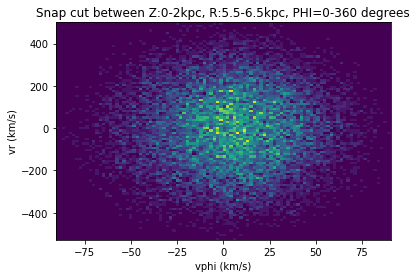

In [190]:
plot_cuts((0,2), (5.5,6.5), (0,360), df, vels="vphi,vr")

In [196]:
def gen_plots(df, *tups, vels=None, path="analysis/"):
    assert df is not None
    params = {'z':[(-10,10)], 'r':[(0,15)], 'phi':[(-180,180)]}
    #default values^^
    for tup in tups:
        start, stop, step, key = tup
        og_start = start
        lst = []
        while start < stop:
            if start + step > stop:
                lst.append((start, stop))
                break
            lst.append((start, start+step))
            start += step
        params[key] = lst
    
    print('starting plotting')
    for z in params['z']:
        for r in params['r']:
            for phi in params['phi']:
                print('.', end='')
                plot_cuts(z, r, phi, df, vels=vels, save=True, path=path)
    print('done')

starting plotting
....................................done
starting plotting
....................................done
starting plotting
....................................done


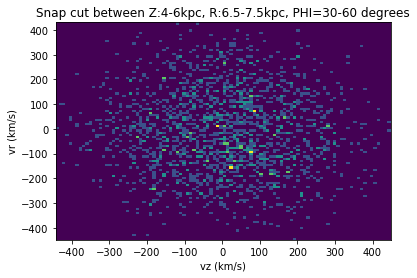

In [199]:
for vels in ['vphi, vr', 'vz, vphi', 'vz, vr']:
    gen_plots(df, (0, 6, 2, "z"), (4.5, 7.5, 1, 'r'), (-60, 60, 30, 'phi'), vels=vels)

starting plotting
....................................done


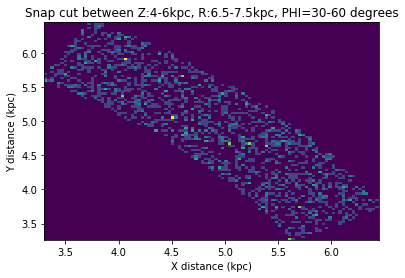

In [192]:
gen_plots(df, (0, 6, 2, "z"), (4.5, 7.5, 1, 'r'), (-60, 60, 30, 'phi'))

In [ ]:
for ztup in [(0,2), (2,4), (4,6)]:
    for phitup in [(-60,-30), (-30, 0), (0, 30), (30,60)]:

In [ ]:
plt.imshow(np.log10(h))

Rs =  1.8726196215911357 2.8770973183672403e-07


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


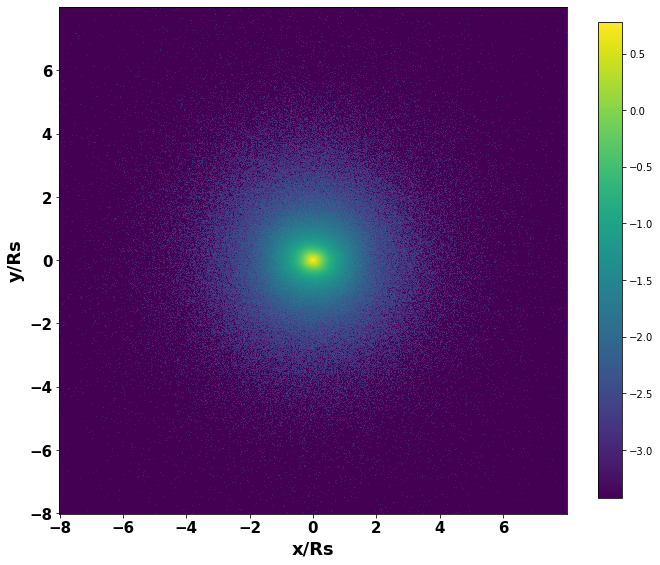

In [189]:
path = "data/snap_582.hdf5"
head, df = read_hdf5(path, p_type=3) #testing with fewer particles
df["x"] = df["x"] - df["x"].median()
df["y"] = df["y"] - df["y"].median()
mass = head["MassTable"][3]
BINS_r, BINS_theta = 360,360
BINS=512
lengthX=15.0
lengthY=15.0
vx0=-5.0
vy0=170.0
Zmin=-4.25
Zmax=-0.27
rmin, rmax = 0., 15.
dtheta=2*np.pi/BINS_theta
dr=(rmax-rmin)/BINS_r
thetamid=(np.arange(BINS_theta)+0.5) * dtheta - np.pi   
rmid=(np.arange(BINS_r)+0.5) * dr + rmin

px,py = df["x"], df["y"]
r=np.sqrt(px**2. + py**2.) 
theta=np.arctan2(py,px)
h, x, y = np.histogram2d(r,theta,bins=[BINS_r,BINS_theta],range=[[rmin,rmax],[-np.pi,np.pi]])

#divide by area to get surface density
for i in range(0,BINS_r):
        h[i,:]/=rmid[i]*dr*dtheta

#fit the axisymmetric surface density            
meanh=np.zeros(BINS_r)
for i in range(0,BINS_r):
        meanh[i]=h[i,:].mean()
z=np.polyfit(rmid, np.log(meanh), 1)
Rs=-1/z[0]
p = np.poly1d(z)
print( "Rs = ", Rs, mass )

#calculate residuals
for i in range(0,BINS_r):
        #h[i,:]=(h[i,:] - np.exp(p(rmid[i]))) / np.exp(p(rmid[i]))
        h[i,:]=(h[i,:] - h[i,:].mean()) / (h[i,:].mean())
Z,x,y=np.histogram2d(px/Rs,py/Rs, range=[[-lengthX/Rs,lengthX/Rs],[-lengthY/Rs,lengthY/Rs]], bins=BINS, normed=True)

Z=np.log10(Z)


Zmin=Z[Z>-np.inf].min()
Zmax=Z[Z<np.inf].max()
if ((Zmax==0.0) & (Zmin==0.0)):
        Zmin=Z[Z>-np.inf].min()
        Zmax=Z.max()
else:
        Z[Z<Zmin]=Zmin
        Z[Z>Zmax]=Zmax
fig = plt.figure(1, figsize=(25.0,25.0))

#left plot
#ax = fig.add_subplot(1,2,1,title=tname+"  t="+str(round(head.time*co.UnitTime_in_Gyr*1000.0,1))+"Myr")

ax = fig.add_subplot(1,2,1) #,title=tname+"  t="+str(round(myTime*co.UnitTime_in_Gyr*1000.0,1))+"Myr")
im=ax.imshow(Z.T, vmin=Zmin, vmax=Zmax,
        origin='lower',interpolation='nearest',
        extent=[-lengthX/Rs,lengthX/Rs,-lengthY/Rs,lengthY/Rs],
        cmap=cm.get_cmap('viridis'))
ax.set_xlabel('x/Rs', fontsize=18, fontweight='bold')
ax.set_ylabel('y/Rs',fontsize=18, fontweight='bold')
plt.xticks(np.arange(-round(lengthX/Rs), round(lengthX/Rs), step=2), fontsize=15, fontweight='bold')
plt.yticks(np.arange(-round(lengthY/Rs), round(lengthY/Rs), step=2), fontsize=15, fontweight='bold')
plt.colorbar(im, shrink=0.35)        